Ecuador Field Site
- Land Surface Temperature
- Land Cover Type
- Ground Elevation


In [52]:
# Modules for the Notebook
import ee
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import optimize
%matplotlib inline 
from IPython.display import Image
import folium

In [53]:
# Personal
# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize(project='ee-karenpedersen2') # make sure the project is your own project, not the one from the tutorial

In [54]:
# Data Products

# land cover
landcover = ee.ImageCollection('MODIS/061/MCD12Q1')
'MODIS/061.MCD12Q1'
# surface temperature
surface_temp = ee.ImageCollection('MODIS/006/MOD11A1')

# elevation
elevation = ee.Image('USGS/SRTMGL1_003')

In [55]:
# Time Period of Interest and Bands of Interest

# Initial date of interest (inclusive)
i_date = '2019-01-01'

# Final date of interest (exclusive)
f_date = '2025-01-01'

# Select the bands from surface_temp
surface_temp = surface_temp.select('LST_Day_1km','QC_Day')

In [56]:
# Forest Point
for_lat = 0.526
for_lon = -79.212
for_point = ee.Geometry.Point(for_lon,for_lat)

# Pasture Point
pas_lat =0.517
pas_lon = -79.219
pas_point = ee.Geometry.Point(pas_lon, pas_lat)

In [57]:
# Functions for extracting variables at points
def pointElev(point, scale, point_name):
    point_info = elevation.sample(point, scale).first().get('elevation').getInfo()
    print(f'Elevation at {point_name} point is:', point_info, 'm')

    lst_point = surface_temp.mean().sample(point, scale).first().get('LST_Day_1km').getInfo()
    print(f'Average daytime surface temp {point_name} point is:', round(lst_point*0.02 - 273.15, 2), '°C')

    lc_point = landcover.first().sample(point, scale).first().get('LC_Type1').getInfo()
    print(f'Land cover value at {point_name} point is:', lc_point)

In [58]:
# Elevation at the two defind points
scale = 1000 # meters
pointElev(point=for_point, scale=scale, point_name="Canandé Forest")

pointElev(point=pas_point,scale=scale,point_name="Canandé Pasture")

Elevation at Canandé Forest point is: 304 m
Average daytime surface temp Canandé Forest point is: 25.57 °C
Land cover value at Canandé Forest point is: 2
Elevation at Canandé Pasture point is: 411 m
Average daytime surface temp Canandé Pasture point is: 25.51 °C
Land cover value at Canandé Pasture point is: 2


Land Cover Type 1 value 2 =  __"Dominated by evergreen broadleaf and palmate
trees (canopy >2m). Tree cover >60%."__

In [59]:
# function to create a df from an array
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [60]:
# convert array to df
lst_for = surface_temp.getRegion(for_point, scale).getInfo()
lst_pas = surface_temp.getRegion(pas_point,scale).getInfo()

lst_df_for = ee_array_to_df(lst_for,['LST_Day_1km'])
lst_df_pas = ee_array_to_df(lst_pas,['LST_Day_1km'])

# function to convert between kelvin and celsius and apply scale
def t_modis_to_celsius(t_modis):
    """Converts MODIS temperature from kelvin to degrees Celsius. """
    t_celsius = 0.02*t_modis - 273.15
    return t_celsius

# Apply the function 
lst_df_for['LST_Day_1km'] = lst_df_for['LST_Day_1km'].apply(t_modis_to_celsius)
lst_df_pas['LST_Day_1km'] = lst_df_pas['LST_Day_1km'].apply(t_modis_to_celsius)

# Check the df
lst_df_for.head()

,time,datetime,LST_Day_1km
10,952214400000,2000-03-05,26.89
36,954460800000,2000-03-31,23.53
53,955929600000,2000-04-17,27.31
54,956016000000,2000-04-18,23.83
72,957744000000,2000-05-08,26.37


In [61]:
# Fitting curves

# X will be time values
x_data_for = np.asanyarray(lst_df_for['time'].apply(float))
x_data_pas = np.asanyarray(lst_df_pas['time'].apply(float))
# Y will be temperature values
y_data_for = np.asanyarray(lst_df_for['LST_Day_1km'].apply(float))
y_data_pas = np.asanyarray(lst_df_pas['LST_Day_1km'].apply(float))

# define the fitting function and parameters
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)
# Optimize the parameters using a good start p0.
# Combine urban and rural temperature data
combined_data = np.concatenate([y_data_for, y_data_pas])

# Calculate lst0 and delta_lst from the combined data
lst0 = combined_data.mean()  # Mean temperature
delta_lst = combined_data.max() - combined_data.min()  # Temperature range
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_pas, params_covariance_pas = optimize.curve_fit(
    fit_func, x_data_pas, y_data_pas, p0=[lst0, delta_lst, tau, phi])
params_for, params_covariance_for = optimize.curve_fit(
    fit_func, x_data_for, y_data_for, p0=[lst0, delta_lst, tau, phi])

print("lst_df_for['datetime'] shape:", lst_df_for['datetime'].shape)
print("x_data_for shape:", x_data_for.shape)
print("fit_func output shape:", fit_func(x_data_for, params_for[0], params_for[1], params_for[2], params_for[3]).shape)

lst_df_for['datetime'] shape: (295,)
x_data_for shape: (295,)
fit_func output shape: (295,)


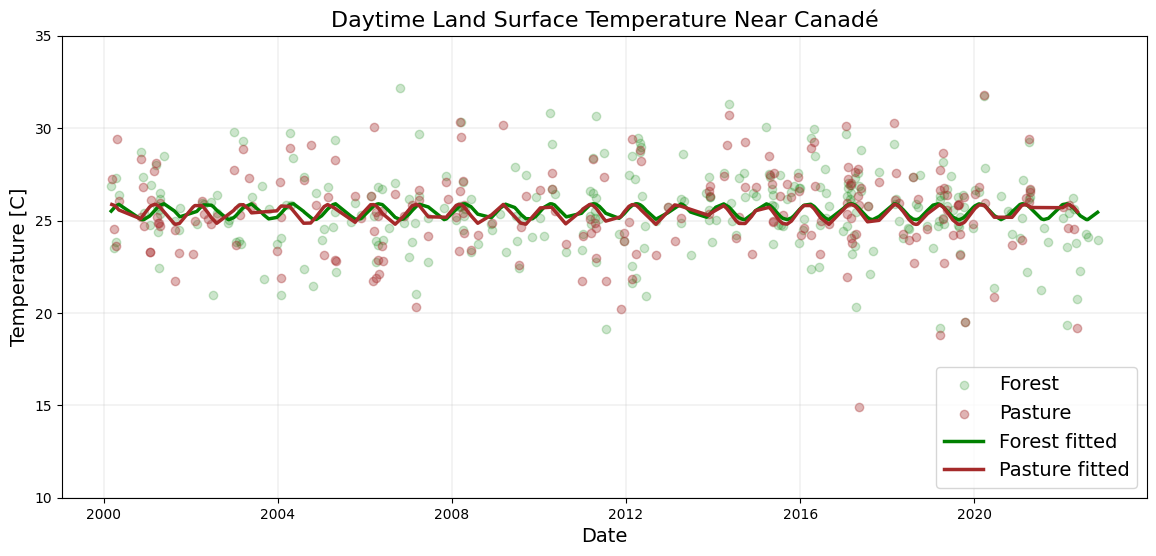

In [62]:

# Visualize the data
fig, ax = plt.subplots(figsize=(14,6))

# Add scatter plots
ax.scatter(lst_df_for['datetime'],lst_df_for['LST_Day_1km'],
           c = 'green', alpha=0.2, label = 'Forest')
ax.scatter(lst_df_pas['datetime'],lst_df_pas['LST_Day_1km'],
           c = 'brown', alpha=0.35, label = "Pasture")

# Add curves from fitted model
ax.plot(lst_df_for['datetime'],
        fit_func(x_data_for, params_for[0],
                 params_for[1],
                 params_for[2],
                 params_for[3]),
                 label="Forest fitted", color = 'green', lw = 2.5)

ax.plot(lst_df_pas['datetime'],
        fit_func(x_data_pas, params_pas[0],
                 params_pas[1],
                 params_pas[2],
                 params_pas[3]),
                 label="Pasture fitted", color = 'brown', lw = 2.5)
# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Canadé', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(10, 35)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

The data here close to the equator in a humid forest are much much less cyclically occilating

In [63]:
# Define the area of interest using the forest point and providing a buffer of 1000 km
area_of_interest = for_point.buffer(1e6)

In [64]:
# Mean temp
lst_img = surface_temp.mean()

# The documentation for this data product suggests that the values should be scaled
lst_img = lst_img.select('LST_Day_1km').multiply(0.02)

# Convert from Kelvin to Celsius
lst_img = lst_img.select('LST_Day_1km').add(-273.15)


In [65]:
url = lst_img.getThumbUrl({
    'min': 10, 'max': 30, 'dimensions':512, 'region': area_of_interest,
    'palette':['blue','yellow','orange','red']})
print(url)

# Display the thumbnail with the color palette
print('\nPlease be patient loading the thumbnail will take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1/projects/ee-karenpedersen2/thumbnails/f527be7557e1858dd6a4bc116d515d21-a729386076960b1a532ee4fda2a5d722:getPixels

Please be patient loading the thumbnail will take a moment...


In [66]:
# this makes pixels with an elevation below sea level transparent
elv_img = elevation.updateMask(elevation.gt(0))

print("It will be worth the wait...")
# Thumbnail of the elevation for the area of interest
Image(url=elv_img.getThumbUrl({
    'min': 0, 'max': 2000, 'dimensions':512, 'region': area_of_interest,
    'palette':['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))



It will be worth the wait...


In [67]:
# create a buffer of ~10 meters around the central point
canande = for_point.buffer(1000) # meters

# elevation map
print("cool elevation map incoming!!!!")
Image(url=elv_img.getThumbURL({
    'min':130, 'max':390, 'region': canande,'dimensions':512,
    'palette':['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']
}))


cool elevation map incoming!!!!


In [73]:
url = lst_img.getThumbUrl({
    'min': 15, 'max': 31, 'dimensions':512, 'region': canande,
    'palette':['blue','yellow','orange','red']})

# Display the thumbnail with the color palette
print('\nPlease be patient loading the thumbnail will take a moment...')
Image(url=url)


Please be patient loading the thumbnail will take a moment...


In [69]:
# city center (more or less)
lat,lon = 0.526,-79.212

map_canande = folium.Map(location=[lat,lon], zoom_start=10)
map_canande

In [70]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [71]:
# Select a specific band and dates for land cover.
lc_img = landcover.select('LC_Type1').filterDate(i_date).first()

# Set visualization parameters for land cover.
lc_vis_params = {
    'min': 1,'max': 17,
    'palette': ['05450a','086a10', '54a708', '78d203', '009900', 'c6b044',
                'dcd159', 'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44',
                'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff']
}

# Create a map.
lat,lon = 0.526,-79.212
my_map = folium.Map(location=[lat, lon], zoom_start=7)

# Add the land cover to the map object.
my_map.add_ee_layer(lc_img, lc_vis_params, 'Land Cover')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)


In [77]:
# Set visualization parameters for ground elevation.
elv_vis_params = {
    'min': 0, 'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Set visualization parameters for land surface temperature.
lst_vis_params = {
    'min': 10, 'max': 40,
    'palette': ['white', 'blue', 'green', 'yellow', 'orange', 'red']}

# Arrange layers inside a list (elevation, LST and land cover).
ee_tiles = [elv_img, lst_img, lc_img]

# Arrange visualization parameters inside a list.
ee_vis_params = [elv_vis_params, lst_vis_params, lc_vis_params]

# Arrange layer names inside a list.
ee_tiles_names = ['Elevation', 'Land Surface Temperature', 'Land Cover']

# Create a new map.
lat,lon = 0.526,-79.212
my_map = folium.Map(location=[lat, lon], zoom_start=5)

# Add layers to the map using a loop.
for tile, vis_param, name in zip(ee_tiles, ee_vis_params, ee_tiles_names):
    my_map.add_ee_layer(tile, vis_param, name)

folium.LayerControl(collapsed = False).add_to(my_map)

my_map
